<a href="https://colab.research.google.com/github/CPTR295/ML1/blob/main/MNIST_Classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MNIST - 70k images of digits handwritten by kids.

In [17]:
import numpy as np
import os

In [11]:
from sklearn.datasets import fetch_openml #since Scikit-Learn 0.24, fetch_openml() returns a Pandas DataFrame by default,use as_frame=False.
mnist = fetch_openml('mnist_784',version=1,as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [12]:
X,y = mnist["data"],mnist['target'] #All scilearn datasets comes with DESCR - describe data sets, data - array of one row per intsance and targer - array of labels

In [13]:
X.shape #70k images with 784 featres = img = 28*28 pixel , pixel=0 white to 255 black

(70000, 784)

In [14]:
y.shape

(70000,)

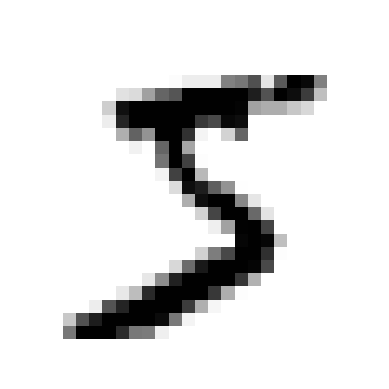

In [15]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()

In [16]:
y[0]

'5'

In [18]:
y=y.astype(np.uint8) #Covert str to int

In [22]:
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:] #sklearn already does split for last 10k

In [24]:
y_train_5 = (y_train==5) #For binary classification 5 and not 5
y_test_5 = (y_test==5)

In [26]:
from sklearn.linear_model import SGDClassifier #Stochastic Gradient Descent - Good for large datasets and online leaning , as it handles row intances independently

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)


SGDClassifier(random_state=42)

In [27]:
sgd_clf.predict([some_digit])

array([ True])

In [30]:
from sklearn.model_selection import StratifiedKFold  #Implementing cross validation or skip to use builtin functions
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,shuffle=True,random_state=42) #if shuffle is false , then random state  is not required
for train_index,test_index in skfolds.split(X_train,y_train_5):
  clone_clf=clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_folds = X_train[test_index]
  y_test_folds = y_train_5[test_index]

  clone_clf.fit(X_train_folds,y_train_folds)
  y_pred = clone_clf.predict(X_test_folds)
  n_correct = sum(y_pred==y_test_folds)
  print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


In [31]:
from sklearn.model_selection import cross_val_score #accuracy is not a good measure here as only 10% od data is 5(Data is skewed)
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [33]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator): #basic claffier class which will return always false for 5
  def fit(self,X,y=None):
    pass
  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool)

In [34]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [35]:
from sklearn.model_selection import cross_val_predict #instead of score we get prediction

y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred) #Row is actual, col is predicted

array([[53892,   687],
       [ 1891,  3530]])

In [37]:
#precision = TP/(TP+FP)
#Recall/Sensitivity = TP/TP+FN

In [38]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5,y_train_pred) #When it claims an image is 5 , its correct only 83%

0.8370879772350012

In [39]:
recall_score(y_train_5,y_train_pred) #It can only detect 65% of 5s. Increasing precision reduces recall(precison_recall_tradeoff)

0.6511713705958311

In [40]:
from sklearn.metrics import f1_score #harmonic mean of precision and recall (2/(1/p)+(1/r))
f1_score(y_train_5,y_train_pred)

0.7325171197343847